<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/TLM_redshift_and_color_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.16
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [60]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/MyDrive/Research/CASTORpz


In [61]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [62]:
names_phot = ["ID", "photoz",
              "LSST_u_MAG",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [63]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [64]:
available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

os_combo_labels = {'LSST-only': 'LSST',
                  'CASTOR-only': 'CASTOR',
                  'LSST+CASTOR': 'LSST+CASTOR',
                  'Roman+LSST': 'LSST+Roman',
                  # 'Roman+LSST+CASTOR' : 'LSST+Roman+CASTOR', #(currently training, will be in Mar_experiments)
                  'Roman+Euclid+LSST': 'LSST+Roman+Euclid',
                  'Roman+Euclid+LSST+CASTOR': 'LSST+Roman+Euclid+CASTOR'}

In [65]:
# tav_cats = {}
# just_tav = {}
# for os in available_os:
#   # print(os)
#   with (open(f"{os}_with_tav.pkl", 'rb')) as openfile:
#     tav_cats[os] = pd.read_pickle(openfile)
#     # print(tav_cats[os].columns)
#     just_tav[os] = tav_cats[os]['log_prob']

In [66]:
# [(tav_cats['LSST-only']['z_true'] > 1.5) & (tav_cats['LSST-only']['z_true'] < 2.25)]

In [67]:
# just_tav['LSST-only'][(tav_cats['LSST-only']['z_true'] > 1.5) & (tav_cats['LSST-only']['z_true'] < 2.25) & tav_cats['LSST-only']['z_true'] < 2.25)]

In [68]:
# u-band cuts on just_tav - 30, 38, 45 second exposures
# distribution of these values
# plot the CDF


In [69]:
# ls reruns_of_old_catalogs/

In [70]:
# flows = FlowEnsemble(file=f"reruns_of_old_catalogs/pzflow_ensemble_for_LSST-only_z15to225.pkl")

In [71]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
CASTOR_baseline = Table.from_pandas(mock_cat)

In [72]:
# put data in expected format for TLM

LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [73]:
which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_z_mag - LSST_y_mag,
                      }
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}

In [98]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR-any'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

In [75]:
LSST_mask = (LSST_u_mag < 25.6) & (LSST_g_mag < 26.9) & (LSST_r_mag < 26.9) & (LSST_i_mag < 26.4) & (LSST_z_mag < 25.6) & (LSST_y_mag < 24.8) #https://www.lsst.org/scientists/keynumbers
CASTOR_mask = (CASTOR_g_mag < 27.5) & (CASTOR_u_mag < 27.5) & (CASTOR_uv_mag < 27.6)
Roman_mask = (Roman_106_mag < 26.7) & (Roman_129_mag < 26.7) & (Roman_158_mag < 26.7) & (Roman_184_mag < 26.7) # https://www.stsci.edu/roman/surveys-and-programs
Euclid_mask = (Euclid_VIS_mag < 26.2) & (Euclid_J_mag < 24.5) & (Euclid_H_mag < 24.5) & (Euclid_Y_mag < 24.5) #https://arxiv.org/pdf/2108.01201

masks = {}

masks['LSST-only'] = LSST_mask
masks['CASTOR-only'] = CASTOR_mask
masks['Roman-only'] = Roman_mask
masks['Euclid-only'] = Euclid_mask

masks['LSST+CASTOR'] = LSST_mask & CASTOR_mask
masks['Euclid+CASTOR'] = Euclid_mask & CASTOR_mask
masks['Roman+CASTOR'] = Roman_mask & CASTOR_mask
masks['Euclid+LSST'] = Euclid_mask & LSST_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Euclid+LSST+CASTOR'] = Euclid_mask & LSST_mask & CASTOR_mask

masks['Roman+Euclid+LSST+CASTOR'] = Roman_mask & Euclid_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+CASTOR'] = Roman_mask & Euclid_mask & CASTOR_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Roman+Euclid+LSST'] = Roman_mask & Euclid_mask & LSST_mask
masks['Euclid+Roman'] = Euclid_mask & Roman_mask

masks['Roman+LSST+CASTOR'] = Roman_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+LSST+CASTOR-any'] = Roman_mask + LSST_mask + Euclid_mask + CASTOR_mask

In [76]:
import scipy.stats as stats

In [99]:
catalogs = test_catalogs
available_os = list(test_catalogs.keys())


# # for os in available_os:
# #   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks[os]]

# catalogs = test_catalogs

# for os in available_os:
#   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks['Roman+Euclid+LSST+CASTOR-any']]

# in the case where we require detection in all surveys simultaneously, the advantage to CASTOR goes away - why?
# now testing the case where we require detection in only one survey

false_mask = np.full(len(catalogs['LSST-only'][masks['Roman+Euclid+LSST+CASTOR']]), False)
false_mask[0:90000] = True

np.random.shuffle(false_mask)

for os in available_os:
  print(os)
  catalogs[os] = catalogs[os][masks['Roman+Euclid+LSST+CASTOR']][false_mask]
  catalogs[os] = catalogs[os][(np.abs(stats.zscore(catalogs[os])) < 5).all(axis=1)]

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR
Euclid+LSST
Roman+LSST
Euclid+Roman
Roman+LSST+CASTOR
Roman+Euclid+CASTOR
Euclid+LSST+CASTOR
Roman+Euclid+LSST
Roman+Euclid+LSST+CASTOR
Roman+Euclid+LSST+CASTOR-any


In [79]:
available_os = list(test_catalogs.keys())

flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"June_12_runs/pzflow_ensemble_for_{os}.pkl")

In [ ]:
# from scipy import stats

In [ ]:
# catalogs = {}

# for os in available_os:
#   catalogs[os] = test_catalogs[os][(np.abs(stats.zscore(test_catalogs[os])) < 3).all(axis=1)]

In [100]:
tav = {}
for os in available_os:
  print(os)
  tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR
Euclid+LSST
Roman+LSST
Euclid+Roman
Roman+LSST+CASTOR
Roman+Euclid+CASTOR
Euclid+LSST+CASTOR
Roman+Euclid+LSST
Roman+Euclid+LSST+CASTOR
Roman+Euclid+LSST+CASTOR-any


In [104]:
np.sum(tav['Euclid+LSST']<-1000)

Array(0, dtype=int32)

In [ ]:
# mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')

# CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts
# CASTOR_baseline = Table.from_pandas(mock_cat) # apply magnitude limit cuts

In [ ]:
# # put data in expected format for TLM

# LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
# LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
# LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
# LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
# LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
# LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")


# # LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# # LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# # LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# # LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

# CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
# CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
# CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# # CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# # CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# # CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

# Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
# Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
# Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
# Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# # Roman - only a subset of the Roman filters are available?

# # Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# # Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
# Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

# Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# # Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
# Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

# Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# # Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

# ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
# z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [ ]:
# # get magnitudes and set up the catalogs

# catalogs = dict()
# catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs["Roman+Euclid+LSST+CASTOR"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag,
#                              '106': Roman_106_mag,
#                              '129 - 106': Roman_129_mag - Roman_106_mag,
#                              '158-129': Roman_158_mag - Roman_129_mag,
#                              '184-158': Roman_184_mag - Roman_158_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs["Roman+Euclid+LSST"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              '106': Roman_106_mag,
#                              '129 - 106': Roman_129_mag - Roman_106_mag,
#                              '158-129': Roman_158_mag - Roman_129_mag,
#                              '184-158': Roman_184_mag - Roman_158_mag
#                       }).set_index('CASTOR_ID').dropna()

In [ ]:

# available_os = ['LSST-only',
#                 'CASTOR-only',
#                 'Euclid+LSST',
#                 'LSST+CASTOR',
#                 'Roman+Euclid+LSST',
#                 'Roman+Euclid+LSST+CASTOR']

# tav = {}
# for os in available_os:
#   tav[os] = flows[os].log_prob(catalogs[os])

In [ ]:
# tav[]

**Dropping bad flows here**

In [ ]:
losses = {}
for os in available_os:
  with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
    losses[os] = pd.read_pickle(openfile)

In [ ]:
flow_list = list(np.linspace(0, 29, 30).astype(int))
bad_flows = {}

for os in available_os:
  bad_flows_list = []
  for flow in flow_list:
    if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
      bad_flows_list.append(flow)
    bad_flows[os] = bad_flows_list

In [ ]:
bad_flows

{'LSST-only': [8, 17, 20],
 'CASTOR-only': [3, 13, 16],
 'Euclid+LSST': [2, 8, 9, 13],
 'LSST+CASTOR': [25, 28],
 'Roman+Euclid+LSST': [2, 5, 14, 16, 19],
 'Roman+Euclid+LSST+CASTOR': [7, 15]}

In [ ]:
just_tav_ensemble = {}
for os in available_os:
  just_tav_ensemble[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

In [ ]:
new_tav = {}

for os in available_os:
  new_tav[os] = np.delete(just_tav_ensemble[os], bad_flows[os], axis = 1)

In [ ]:
for os in available_os:
  print(new_tav[os].shape)

(108330, 27)
(108330, 27)
(108330, 26)
(108330, 28)
(108330, 25)
(108330, 28)


**Redshift Binned Plots**

In [37]:
import scipy.stats as sps

In [ ]:
available_os

['LSST-only',
 'CASTOR-only',
 'Roman-only',
 'Euclid-only',
 'LSST+CASTOR',
 'Euclid+CASTOR',
 'Roman+CASTOR',
 'Euclid+LSST',
 'Roman+LSST',
 'Euclid+Roman',
 'Roman+LSST+CASTOR',
 'Roman+Euclid+CASTOR',
 'Euclid+LSST+CASTOR',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

In [34]:
def compute_milb(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [35]:
# entropy term

def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  # for os in available_os:
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]

      # print(catalogs[os].columns)

      # print('shape is: ')

      # print(np.shape(catalogs[os]))

    print(all_tlm[os])
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      print(zmax)
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(subset['logprob'])
      # mean = np.mean(vals[vals >   -3])
      # print(mean)
      # std = np.std(vals[vals > -3])
      std = np.std(subset['logprob'])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [ ]:
# (catalogs['LSST-only']['z_true'] <= zmax)
# catalogs['LSST-only']['z_true']

In [ ]:
# zmin = 0.03
# zmax = 1
# print(catalogs['LSST-only'][(catalogs['LSST-only']['z_true'] <= zmax)]) # & (catalogs['LSST-only']['z_true'] < zmax)])
# print(catalogs['LSST-only'][(catalogs['LSST-only']['z_true'] >= zmin) & (catalogs['LSST-only']['z_true'] < zmax)])

In [ ]:
available_os = ['LSST-only', 'Roman+Euclid+LSST+CASTOR-any']

In [105]:
all_tlm, is_inf_mask = compute_milb(tav, available_os)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['LSST-only', 'CASTOR-only', 'Roman-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Roman+CASTOR', 'Euclid+LSST', 'Roman+LSST', 'Euclid+Roman', 'Roman+LSST+CASTOR', 'Roman+Euclid+CASTOR', 'Euclid+LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR', 'Roman+Euclid+LSST+CASTOR-any']


<ipython-input-34-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


LSST-only
[ 3.9986796   1.1687522   2.6655364  ...  3.8645308  -0.24283755
  3.5858455 ]
0.030303030303030304
0.06060606060606061
0.09090909090909091
0.12121212121212122
0.15151515151515152
0.18181818181818182
0.21212121212121213
0.24242424242424243
0.2727272727272727
0.30303030303030304
0.33333333333333337
0.36363636363636365
0.3939393939393939
0.42424242424242425
0.4545454545454546
0.48484848484848486
0.5151515151515151
0.5454545454545454
0.5757575757575758
0.6060606060606061
0.6363636363636364
0.6666666666666667
0.696969696969697
0.7272727272727273
0.7575757575757576
0.7878787878787878
0.8181818181818182
0.8484848484848485
0.8787878787878788
0.9090909090909092
0.9393939393939394
0.9696969696969697
1.0
1.0303030303030303
1.0606060606060606
1.0909090909090908
1.1212121212121213
1.1515151515151516
1.1818181818181819
1.2121212121212122
1.2424242424242424
1.2727272727272727
1.303030303030303
1.3333333333333335
1.3636363636363638
1.393939393939394
1.4242424242424243
1.4545454545454546
1.4

In [ ]:
avgtav

{'LSST-only': array([-5.94448328e-01, -5.04573166e-01, -1.87761605e-01,  2.26532556e-02,
        -1.88408598e-01, -1.75085858e-01,  1.16578698e-01,  8.10480893e-01,
         6.89315259e-01,  6.20965362e-01,  1.07095194e+00,  1.36690104e+00,
         1.49997687e+00, -2.06081844e+33,  1.90779662e+00,  1.53281856e+00,
         1.77505541e+00,  1.82114899e+00, -1.84255119e+33,  1.53125560e+00,
        -2.14216146e+33,  2.73793316e+00,  2.62879419e+00,  2.34296989e+00,
         2.52512550e+00,  2.28452587e+00,  1.61973870e+00,  2.13458323e+00,
         1.94820511e+00,  2.21523952e+00, -1.46094086e+33,  2.27327132e+00,
         2.23632765e+00,  1.45160961e+00, -2.22145415e+33,  1.60311151e+00,
         1.57268465e+00,  1.96012545e+00,  1.60164106e+00,  1.75864625e+00,
         1.80373418e+00,  1.85339248e+00,  1.83551097e+00,  1.34448421e+00,
         1.12517130e+00,  1.42900932e+00,  1.44312096e+00,  1.25163889e+00,
         1.32073236e+00,  1.47904551e+00,  5.21849215e-01, -4.58292737e+33,

LSST-only
0
-1.0256441732872812
CASTOR-only
0
-0.40575724840164185
Roman-only
0
0.0
Euclid-only
0
-0.18921197950839996
LSST+CASTOR
0
4.9317021291424e-310
Euclid+CASTOR
0
0.0
Roman+CASTOR
0
6.73319350615775e-310
Euclid+LSST
0
1.848524808883667
Roman+LSST
0
0.000294774478668394
Euclid+Roman
0
0.000294774478668394
Roman+LSST+CASTOR
0
-0.20810382068157196
Roman+Euclid+CASTOR
0
-0.3284385969511163
Euclid+LSST+CASTOR
0
0.10563308745622635
Roman+Euclid+LSST
0
0.23112951619057753
Roman+Euclid+LSST+CASTOR
0
-0.01160120964050293


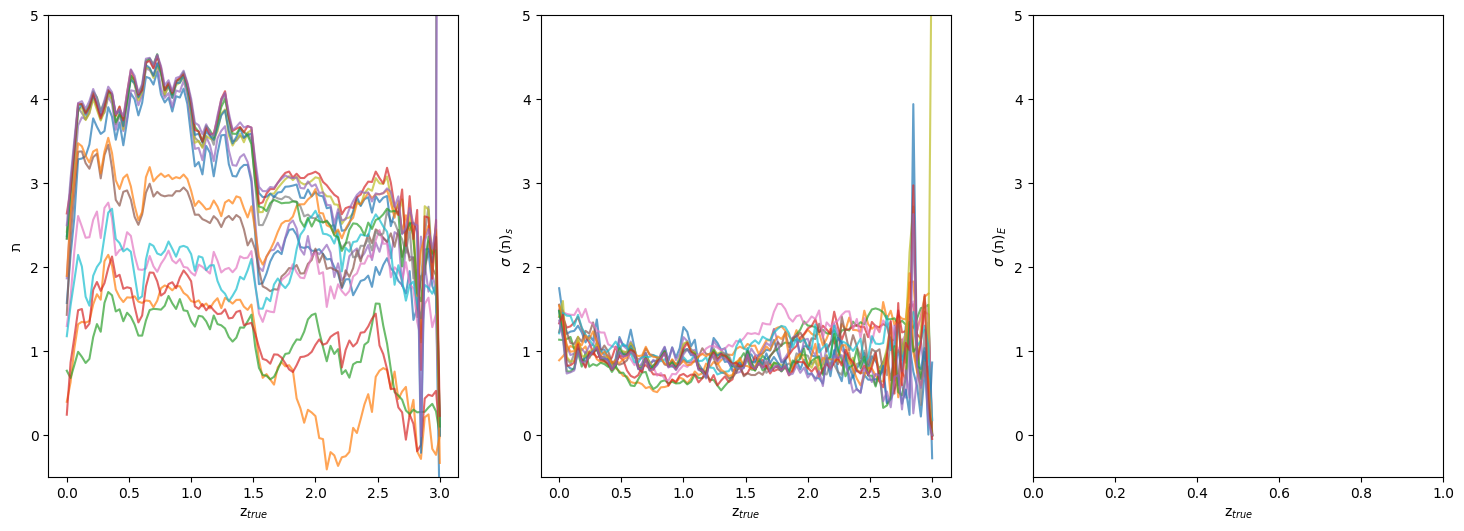

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in available_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)
  # ax[2].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
ax[1].set_ylim(-0.5, 5)

ax[2].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylim(-0.5, 5)

# plt.savefig('redshift_binned_with_uncertainty_same_scales.png')
plt.show()

# ax[0].set_ylim(-2, 5)

In [ ]:
available_os

['LSST-only',
 'CASTOR-only',
 'Roman-only',
 'Euclid-only',
 'LSST+CASTOR',
 'Euclid+CASTOR',
 'Roman+CASTOR',
 'Euclid+LSST',
 'Roman+LSST',
 'Euclid+Roman',
 'Roman+LSST+CASTOR',
 'Roman+Euclid+CASTOR',
 'Euclid+LSST+CASTOR',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

In [ ]:
LSST_os = ['LSST-only',
           'LSST+CASTOR',
           'Euclid+LSST',
           'Roman+LSST']

Roman_os = ['Roman-only',
            'Euclid+Roman',
            'Roman+LSST',
            'Roman+CASTOR']

CASTOR_os = ['CASTOR-only',
             'Euclid+CASTOR',
             'LSST+CASTOR',
             'Roman+CASTOR']

Euclid_os = ['Euclid-only',
             'Euclid+Roman',
             'Euclid+CASTOR',
             'Euclid+LSST']

LSST-only
0
-1.0256441732872812
LSST+CASTOR
0
4.9317021291424e-310
Euclid+LSST
0
1.848524808883667
Roman+LSST
0
0.000294774478668394
Roman-only
0
0.0
Euclid+Roman
0
0.000294774478668394
Roman+LSST
0
0.000294774478668394
Roman+CASTOR
0
6.73319350615775e-310
CASTOR-only
0
-0.40575724840164185
Euclid+CASTOR
0
0.0
LSST+CASTOR
0
4.9317021291424e-310
Roman+CASTOR
0
6.73319350615775e-310
Euclid-only
0
-0.18921197950839996
Euclid+Roman
0
0.000294774478668394
Euclid+CASTOR
0
0.0
Euclid+LSST
0
1.848524808883667


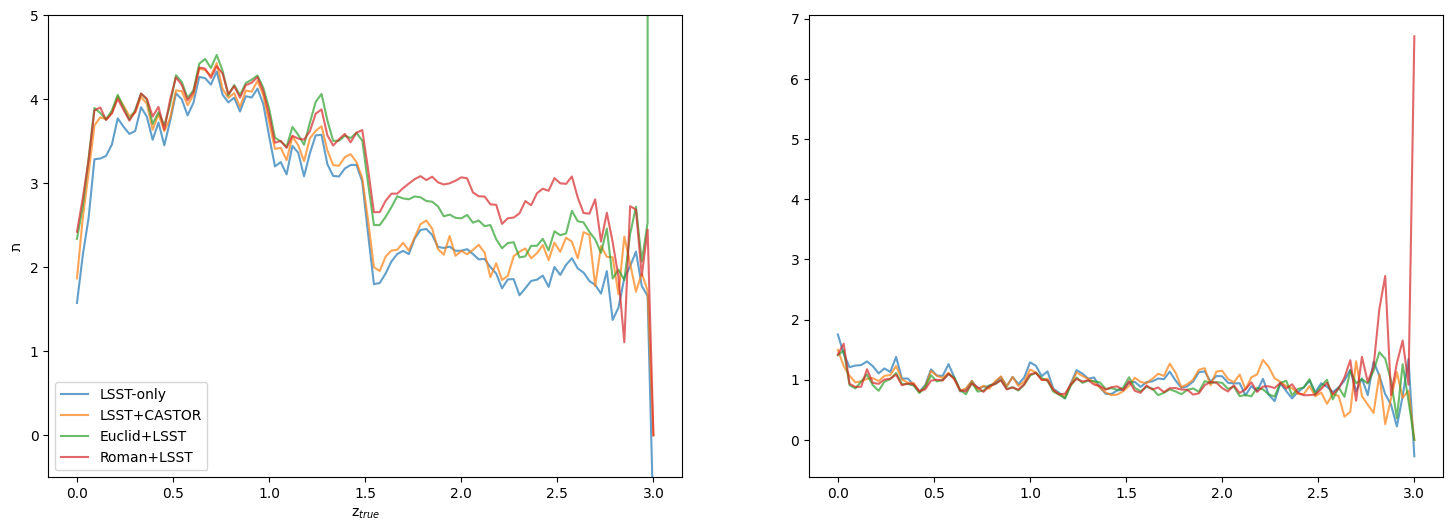

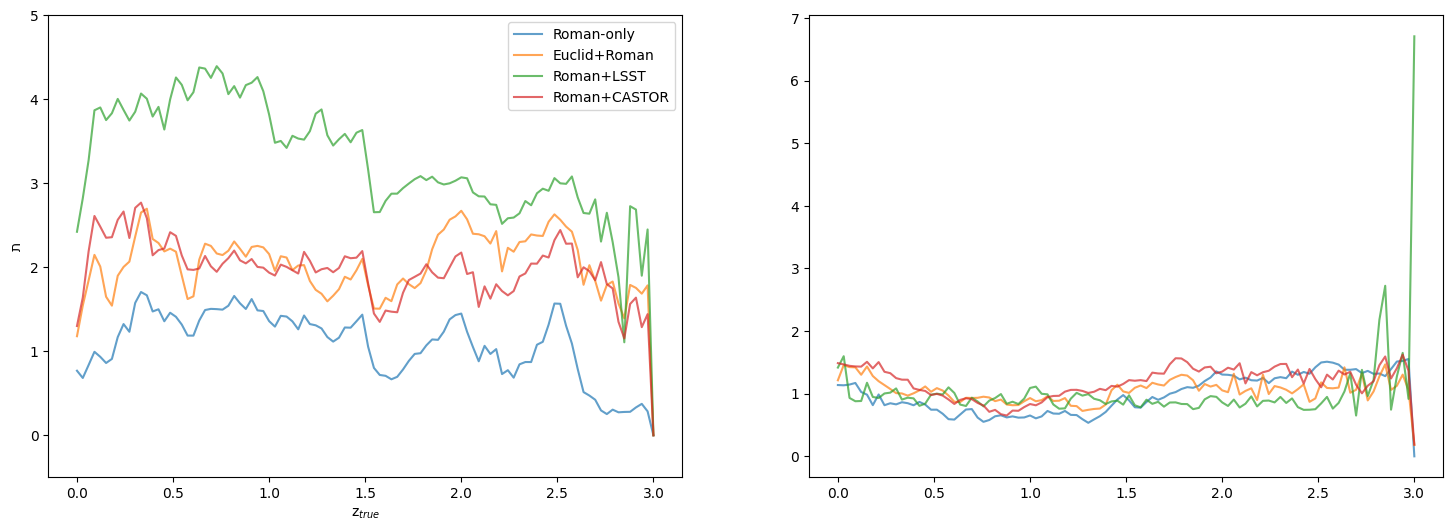

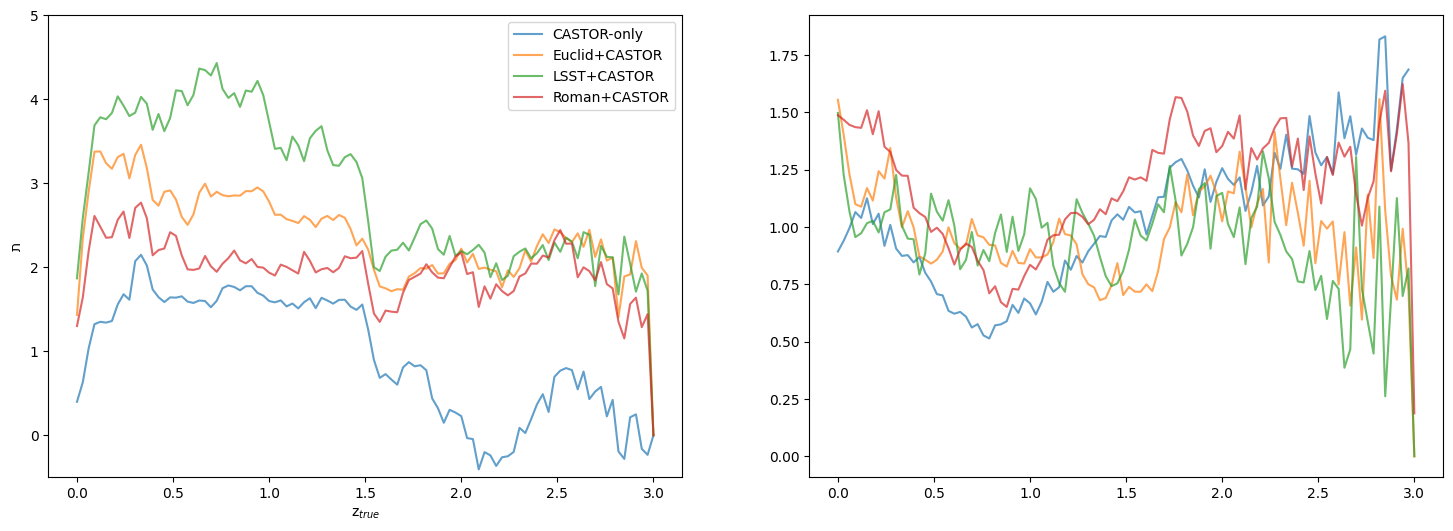

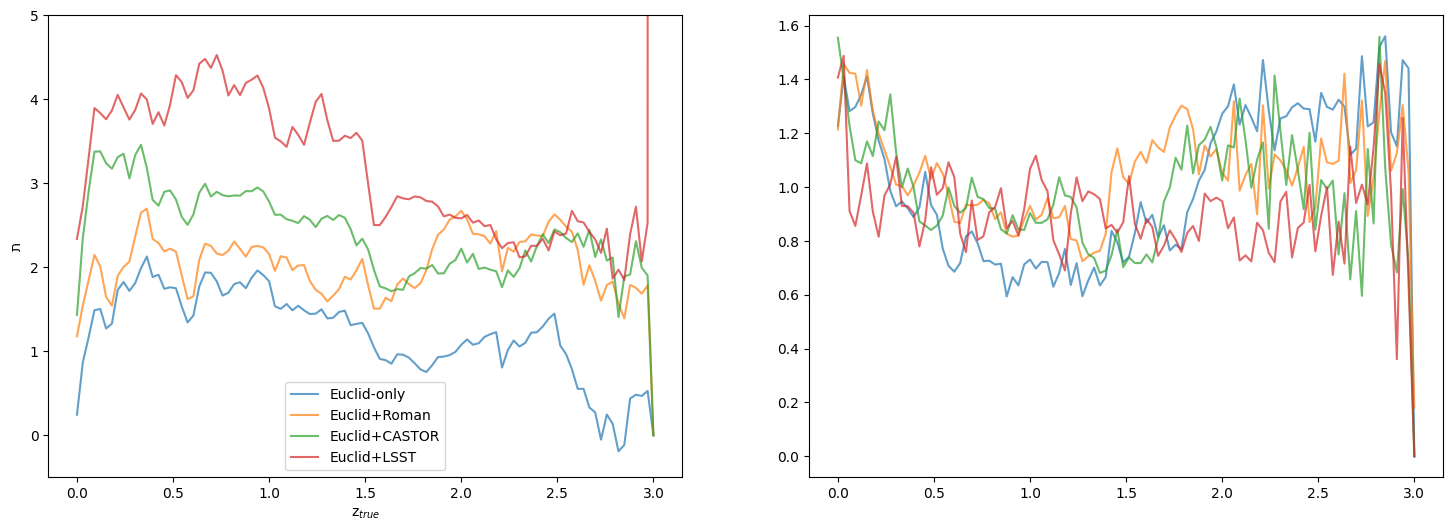

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in LSST_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in Roman_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()


fig, ax = plt.subplots(1, 2, figsize = (18, 6))


for os in CASTOR_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

fig, ax = plt.subplots(1, 2, figsize = (18, 6))


for os in Euclid_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)

ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

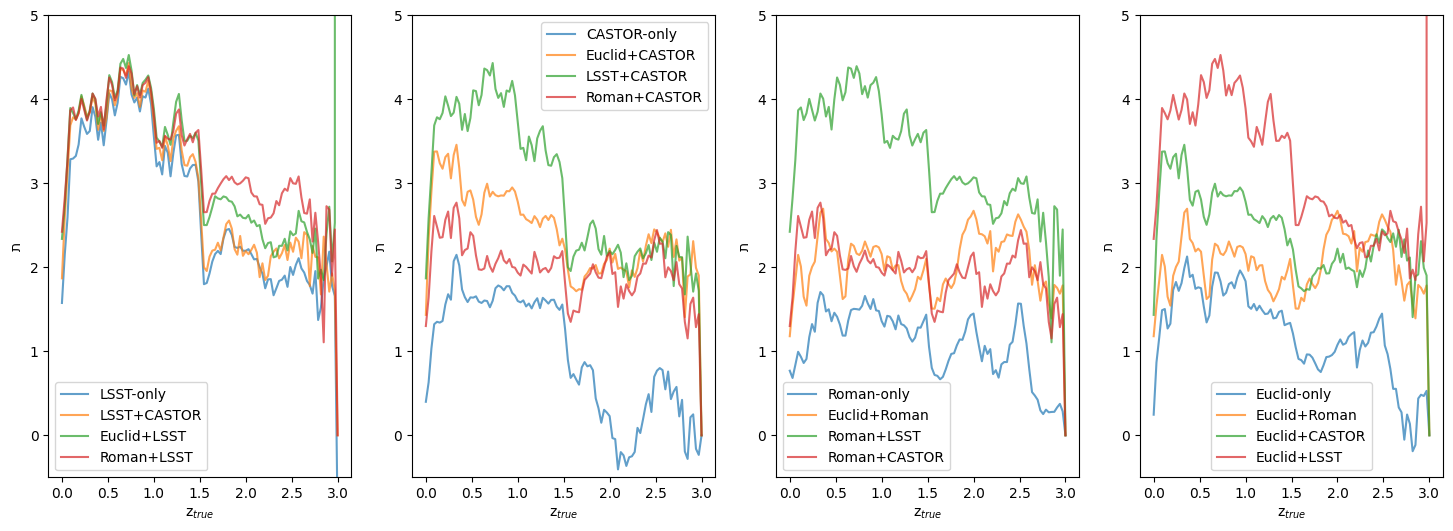

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in LSST_os:
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)

for os in Roman_os:
  ax[2].plot(zbins, avgtav[os], label=os, alpha=0.7)

for os in CASTOR_os:
  ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

for os in Euclid_os:
  ax[3].plot(zbins, avgtav[os], label=os, alpha=0.7)


ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-0.5, 5)
ax[1].legend()

ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylabel(chr(0x05ea))
ax[2].set_ylim(-0.5, 5)
ax[2].legend()

ax[3].set_xlabel('z$_{true}$')
ax[3].set_ylabel(chr(0x05ea))
ax[3].set_ylim(-0.5, 5)
ax[3].legend()

In [ ]:
available_os

['LSST-only',
 'CASTOR-only',
 'Roman-only',
 'Euclid-only',
 'LSST+CASTOR',
 'Euclid+CASTOR',
 'Roman+CASTOR',
 'Euclid+LSST',
 'Roman+LSST',
 'Euclid+Roman',
 'Roman+LSST+CASTOR',
 'Roman+Euclid+CASTOR',
 'Euclid+LSST+CASTOR',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

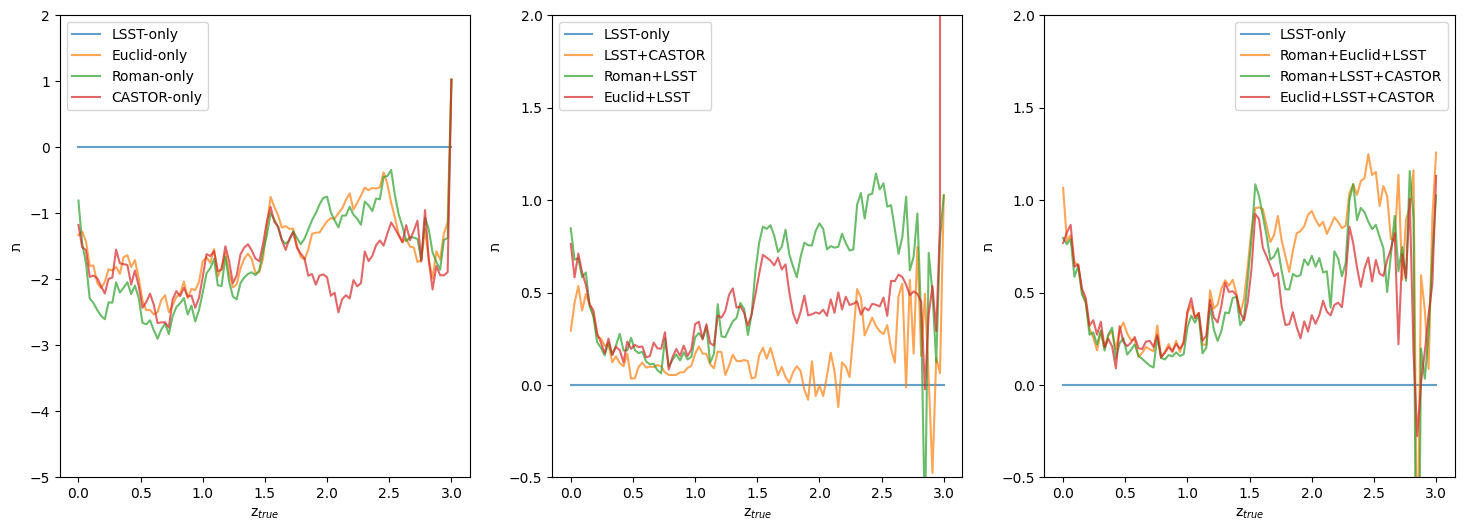

In [ ]:
single_os = ['LSST-only',
                 'Euclid-only',
                 'Roman-only',
                 'CASTOR-only']

two_os = ['LSST-only',
          'LSST+CASTOR',
          'Roman+LSST',
          'Euclid+LSST']

three_os = ['LSST-only',
            'Roman+Euclid+LSST',
            'Roman+LSST+CASTOR',
            'Euclid+LSST+CASTOR']

fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in single_os:
  ax[0].plot(zbins, avgtav[os] - avgtav['LSST-only'], label=os, alpha=0.7)

for os in two_os:
  ax[1].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


for os in three_os:
  ax[2].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-5, 2)
ax[0].legend()

ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-0.5, 2)
ax[1].legend()

ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylabel(chr(0x05ea))
ax[2].set_ylim(-0.5, 2)
ax[2].legend()



In [ ]:
print(catalogs['LSST-only'].describe())
print(catalogs['CASTOR-only'].describe())
print(catalogs['Euclid-only'].describe())
print(catalogs['Roman-only'].describe())

             z_true             r           u-g           g-r           r-i  \
count  93451.000000  93451.000000  93451.000000  93451.000000  93451.000000   
mean       0.930896     23.803721      0.344776      0.411073      0.360304   
std        0.477202      0.921701      0.285975      0.320774      0.244005   
min        0.020100     21.153990     -1.401706     -0.799049     -0.530725   
25%        0.581700     23.250825      0.156767      0.160481      0.163317   
50%        0.888500     23.961852      0.279376      0.320017      0.312153   
75%        1.234000     24.503052      0.465536      0.629880      0.549052   
max        3.005400     25.836993      2.433796      1.691936      1.444229   

                i-z           z-y       logprob  
count  93451.000000  93451.000000  93451.000000  
mean       0.251419      0.196281      3.633287  
std        0.201112      0.168104      1.122307  
min       -0.833481     -0.990875     -9.084731  
25%        0.100961      0.094918     

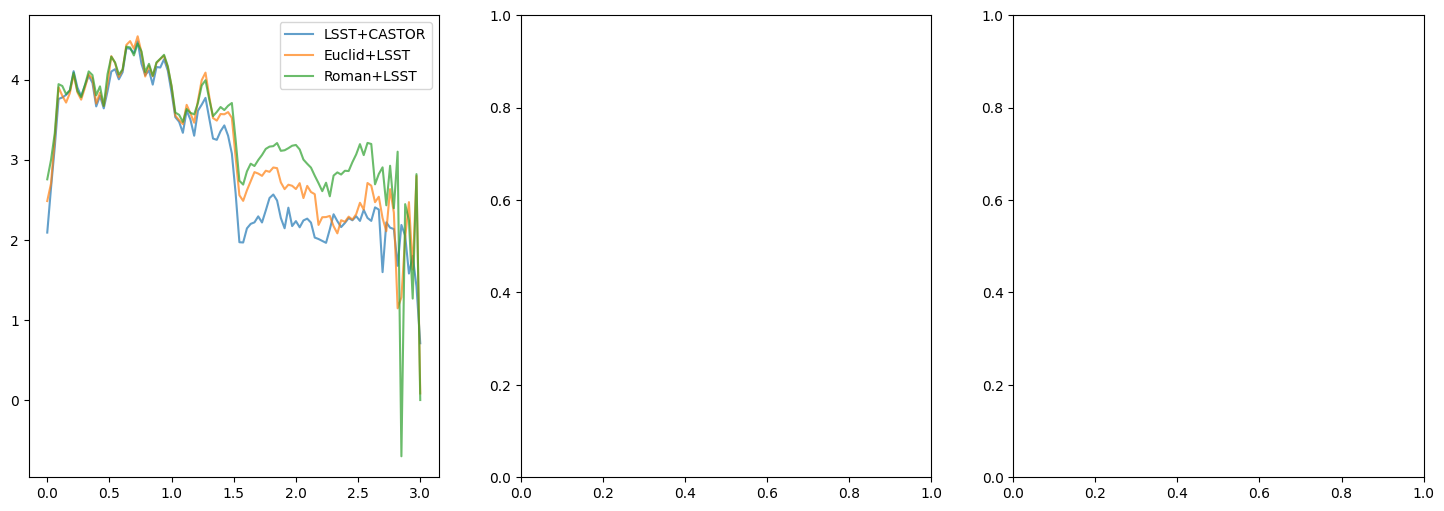

In [115]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)

for os in ['LSST+CASTOR', 'Euclid+LSST', 'Roman+LSST']:
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
ax[0].legend()

In [ ]:
catalogs['LSST-only'].describe()
catalogs['Euclid-only'].describe()

,z_true,v,v-y,y-j,j-h,logprob
count,356137.000000,356137.000000,356137.000000,356137.000000,356137.000000,356137.000000
mean,1.122987,25.119202,0.612206,0.221261,0.090340,0.890590
std,0.680365,1.325200,0.545003,0.489644,0.469145,1.387285
min,0.020100,20.892275,-1.569294,-1.972598,-1.992058,-18.072918
25%,0.616500,24.296269,0.322861,0.003146,-0.109406,0.391334
50%,0.994400,25.317732,0.628364,0.199739,0.099996,1.211732
75%,1.479300,26.125797,0.930113,0.422974,0.322571,1.730352
max,3.454200,29.281030,2.669016,2.449276,2.169130,4.512432


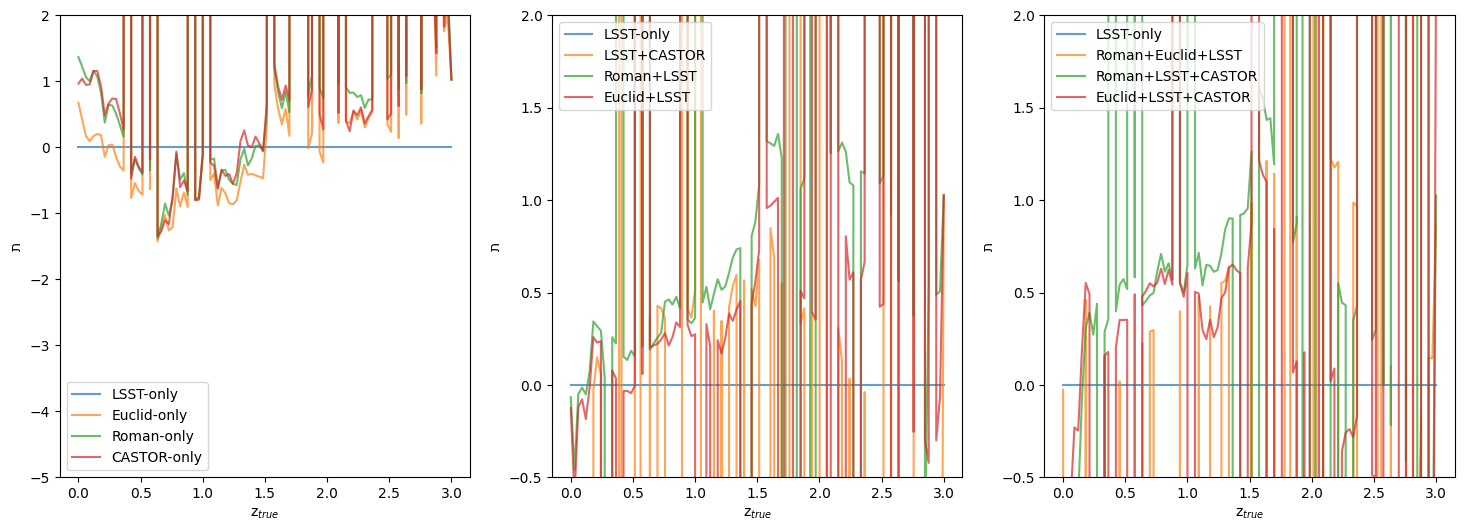

In [ ]:
single_os = ['LSST-only',
                 'Euclid-only',
                 'Roman-only',
                 'CASTOR-only']

two_os = ['LSST-only',
          'LSST+CASTOR',
          'Roman+LSST',
          'Euclid+LSST']

three_os = ['LSST-only',
            'Roman+Euclid+LSST',
            'Roman+LSST+CASTOR',
            'Euclid+LSST+CASTOR']

fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in single_os:
  ax[0].plot(zbins, avgtav[os] - avgtav['LSST-only'], label=os, alpha=0.7)

for os in two_os:
  ax[1].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


for os in three_os:
  ax[2].plot(zbins, avgtav[os]- avgtav['LSST-only'], label=os, alpha=0.7)


ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-5, 2)
ax[0].legend()

ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel(chr(0x05ea))
ax[1].set_ylim(-0.5, 2)
ax[1].legend()

ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylabel(chr(0x05ea))
ax[2].set_ylim(-0.5, 2)
ax[2].legend()

In [ ]:
def compute_milb_ensemble(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = all_milb[os] + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    # all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [ ]:
all_tlm, is_inf_mask = compute_milb_ensemble(new_tav, available_os)


['LSST-only', 'CASTOR-only', 'Euclid+LSST', 'LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']


<ipython-input-55-2c69b1faeef8>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [ ]:
np.shape(all_tlm['LSST-only'])

(108330, 27)

In [ ]:
type(all_tlm['LSST-only'])

numpy.ndarray

In [ ]:
import numpy.ma as ma

In [ ]:
epistemic_variance = {}
redshifts = {}

for os in available_os:
  epistemic_variance[os] = ma.array(all_tlm[os], mask = ~(np.abs(all_tlm[os]) < 100)).std(axis=1).data
  redshifts[os] = ma.array(catalogs[os]['z_true'], mask = ~(np.abs(all_tlm[os].mean()) < 100)).data

In [ ]:
binned_variance = {}

for os in available_os:
  print(epistemic_variance[os].shape)
  print(redshifts[os].shape)

  ploterr = np.empty_like(zbins)
  for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      ploterr[i] = np.mean(epistemic_variance[os][(redshifts[os] >=zmin) & (redshifts[os] < zmax)])

      binned_variance[os] = ploterr



(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)


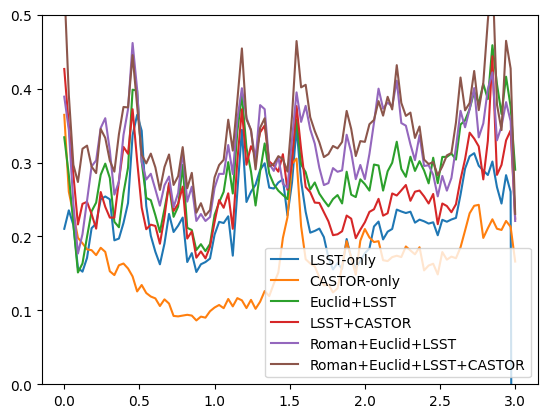

In [ ]:
for os in available_os:
  plt.plot(zbins, binned_variance[os], label = os)
  plt.ylim(0, 0.5)

  plt.legend()

possibly a consequence of weird values in the catalogs --> more surveys compounds this effect. "Mo surveys, mo problems" - Alex Malz

different surveys use different placeholders for bad values --> as you combine surveys, how many notions --> value of bad values --> coherent surveys, how do notions of bad values impact survey metrics --> good sample size gets smaller with more surveys

In [ ]:
redshifts['LSST-only'].shape

(430635,)

In [ ]:
a = np.array(catalogs[os]['z_true'])

In [ ]:
np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1)

(430635, 27)

In [ ]:

for os in available_os:
    ploterr = np.empty_like(zbins)
    # catalogs[os] = catalogs[os][(np.abs(all_tlm[os]) < 100)]

    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      # subset = epistemic_variance[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]

      subset = ma.array(all_tlm[os], mask = ~(np.abs(all_tlm[os]) < 100) & (np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1) >= zmin) & (np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1) < zmax)).std(axis=1).data

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ValueError: operands could not be broadcast together with shapes (430635,26) (430635,27) 

In [ ]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = epistemic_variance
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]
      print(catalogs[os].columns)

      print('shape is: ')

      print(np.shape(catalogs[os]))
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(vals[vals >   -3])
      # print(mean)
      std = np.std(vals[vals > -3])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

(430635,)

In [ ]:
A = np.array([[1, 2], [3, np.inf]])
A

~np.isfinite(all_tlm['LSST-only']) & (np.abs(all_tlm['LSST-only']) < 100)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
ma.array(A, mask = ~np.isfinite(A)).std()

0.816496580927726

In [ ]:
import numpy.ma as ma

In [ ]:
def compute_milb_stats(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  new_tlm = {}
  std_tlm = {}

  print(available_os)

  for os in available_os:

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy

    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]

    print(np.shape(milb))


    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb + entropy

    standards = []

    for i in range(0, np.shape(all_tlm[os])[1]):

      standards.append(np.std(all_tlm[os][:,i][np.isfinite(all_tlm[os][:,i])]))

      std_tlm[os] = standards

    # all_tlm_std = all_tlm[os].std(axis=1, where = ~np.isinf(all_tlm[os]))

  return std_tlm

In [ ]:

std_tlm = compute_milb_stats(new_tav, available_os)


['LSST-only', 'CASTOR-only', 'Euclid+LSST', 'LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']
(430635, 27)


<ipython-input-359-c1c8f712d9b6>:18: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


(430635, 27)
(430635, 26)
(430635, 28)
(430635, 25)
(430635, 28)


In [ ]:
std_tlm['LSST-only']

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [ ]:
np.max(all_tlm_std)

inf

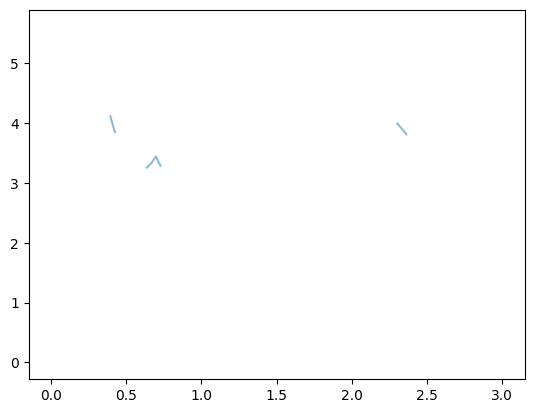

In [ ]:
for os in available_os:
  vals = np.zeros_like(zbins)

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]

    subset = all_tlm_std[(z_true > zmin) & (z_true < zmax)]
    vals[i] = np.mean(subset)

plt.plot(zbins, vals, label=os, alpha=0.5)


In [ ]:
vals

array([5.61689091,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
       4.29682207,        inf,        inf, 4.11501408, 3.84934044,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.25604939, 3.33084249, 3.44355536, 3.28679085,
              inf,        inf, 3.36345959,        inf,        inf,
       3.04792452,        inf,        inf,        inf,        inf,
       3.72727346,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.65883517,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf, 4.26099634,        

In [ ]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]
      print(catalogs[os].columns)

      print('shape is: ')

      print(np.shape(catalogs[os]))
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(vals[vals >   -3])
      # print(mean)
      std = np.std(vals[vals > -3])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [ ]:
np.shape(all_tlm_le['LSST-only'])

(318745,)

In [ ]:
drops = ['drop_uv', 'drop_u', 'drop_g']

In [ ]:
flows_drops = {}
flows_drops['drop_uv'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_uv.pkl")
flows_drops['drop_u'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_u.pkl")
flows_drops['drop_g'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_g.pkl")

In [ ]:
catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'uv': CASTOR_uv_mag,
                              'u':   CASTOR_u_mag,
                             'g': CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

In [ ]:
just_tav_drops = {}

just_tav_drops['drop_uv'] = flows_drops['drop_uv'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_u'] = flows_drops['drop_u'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_g'] = flows_drops['drop_g'].log_prob(catalogs['LSST+CASTOR'])

In [ ]:
all_tlm, is_inf_mask = compute_milb(just_tav_drops, drops)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['drop_uv', 'drop_u', 'drop_g']


KeyError: 'drop_uv'

In [ ]:
all_tlm[available_os[1]].shape

KeyError: 'CASTOR-only'

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)